<a href="https://colab.research.google.com/github/N-avi-N/BERT_Notebooks/blob/main/Finetune_Bert_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blog Link + Source code
http://mccormickml.com/2019/07/22/BERT-fine-tuning/

https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=oCYZa1lQ8Jn8

# Check for GPU

In [ ]:
import tensorflow as tf

# get the GPU device name
device_name = tf.test.gpu_device_name()

# the device name should look like followng
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# Import Pytorch, Check GPU name

In [ ]:
import torch

# check if GPU available
if torch.cuda.is_available():

  # tell torch to use GPU
  device = torch.device('cuda')

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU ', torch.cuda.get_device_name(0))

else:
  print('No GPU available, using CPU instead')
  device = torch.device('cpu')

There are 1 GPU(s) available.
we will use the GPU  Tesla T4


Installing HuggingFace library

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 7.5 MB/s 
     |████████████████████████████████| 636 kB 62.0 MB/s 
     |████████████████████████████████| 3.3 MB 60.0 MB/s 
     |████████████████████████████████| 895 kB 59.2 MB/s 
     |████████████████████████████████| 50 kB 9.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Load Cola Dataset

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=a10771042af0e7b4ce9bbf421787f950406b476c4421dd55ef6ee5ccd9c7a932
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import wget 
import os

print('Downloading dataset')

# Url for data file 
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
# unzip the dataset
#if not os.path.exists('./cola_public_1.1.zip'):
!unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


# Parse the dataset 

In [ ]:
import pandas as pd

# load data to pandas dataframe
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, 
              names=['sentence_source', 'label', 'label_notes', 'sentence'])

# get count of sentences in data
print('Number of training sentences: {:,}'.format(df.shape[0]))

# print 10 random rows
df.sample(10)

Number of training sentences: 8,551


,sentence_source,label,label_notes,sentence
1186,r-67,1,NaN,"I divulged when Bill promised to call me, but ..."
761,bc01,1,NaN,The gardener watered the tulips flat.
3228,l-93,0,*,The Romans destroyed ruins from the city.
7681,sks13,1,NaN,John believes the rice to have been cooked by ...
7645,sks13,1,NaN,Only Churchill remembered himself giving the B...
6852,m_02,0,*,Only the best students would he give this book.
4174,ks08,0,*,One people was dying of thirst.
3314,l-93,0,*,The magician echoed the music.
6956,m_02,1,NaN,Frank Churchill crosses the street.
98,gj04,1,NaN,The off center spinning flywheel shook itself ...


In [ ]:
df.loc[df['label'] == 0].sample(5)[['sentence', 'label']]

,sentence,label
5436,She's enough tall.,0
2105,I lent Tony the book halfway.,0
2111,The old dog died partway.,0
3556,He walked right the wall.,0
1840,That they spoke to the janitor about that robb...,0


In [ ]:
# get list of sentences and labels
sentences = df['sentence'].values
labels = df['label'].values

# Tokenization and input formating

In [ ]:
from transformers import BertTokenizer

# load the BERT tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# print original sentence
print('Original: ', sentences[0])

# print the sentence split into tokens
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# print the mapped token id's
print('Token ids: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token ids:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [ ]:
# Find max sentence length
max_len = 0

for sent in sentences:

  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  max_len = max(max_len, len(input_ids))

print('Max sentence length is :', max_len)

Max sentence length is : 47


# Convert sentences to Token id's, and add attention masks

Padding and Truncating sentences

In [ ]:
input_ids = []
attention_masks = []

for sentence in sentences:

  # encode a sentence
  encoded_dict = tokenizer.encode_plus(
                            sentence,
                            add_special_tokens = True, # add 'CLS' and 'SEP' token
                            max_length = 64,
                            padding = 'max_length',
                            return_attention_mask = True,
                            return_tensors = 'pt'
                            )
  
  # add encoded sentence to the list
  input_ids.append(encoded_dict['input_ids'])

  # get the attention layer for the sentence
  attention_masks.append(encoded_dict['attention_mask'])


# convert lists to tensors
input_ids = torch.cat(input_ids)
attention_masks = torch.cat(attention_masks)
labels = torch.tensor(labels)


# print original sentence and the encoded sentence
print('Original: ', sentences[0])
print('Token ids: ', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token ids:  tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# Train test split
use 'tensordataset' to split tokenes and masks

In [ ]:
from torch.utils.data import TensorDataset, random_split

# combine tokens, att masks and labels to tensordataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# split the data to 90/10 split randomly
train_size = int(len(dataset)*0.9)
val_size = len(dataset) - train_size

train_dataset, val_dataset  = random_split(dataset, [train_size, val_size])

print('Training data size {:,}'.format(train_size))
print('Validaton data size {:,}'.format(val_size))

Training data size 7,695
Validaton data size 856


Define data loader

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# train dataloader
train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset),
                              batch_size = batch_size)

# validation dataloader
validation_dataloader = DataLoader(val_dataset,
                                   sampler = RandomSampler(val_dataset),
                                   batch_size = batch_size)

# Train Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# load the pretrained Bert model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False,
                                                      )

# pass model to cuda
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# view layers of Bert
parms = list(model.named_parameters())

print('The Bert model has {:} different named parameters.\n'.format(len(parms)))

print('\n*** Embedding Layer ***\n')
# first 5 layers are the embedding layers
for p in parms[0:5]:
  print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n*** First Transformer Layer ***\n')
for p in parms[5:21]:
  print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n*** Output Layer ***\n')
for p in parms[-4:]:
  print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))




The Bert model has 201 different named parameters.


*** Embedding Layer ***

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

*** First Transformer Layer ***

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias            

# Optimizer and Learning Rate scheduler

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-5)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# we will train the modle 4 times on all the train data
total_steps = len(train_dataloader) * epochs

# create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


# Training Loop

Helper function to calculate **accuracy**

In [ ]:
import numpy as np

# Function to calculate accuracy of predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  return np.sum(pred_flat == labels_flat) / len(labels_flat)


Helper function to calculate elapsed time

In [ ]:
import time
import datetime

# takes input as secs and return hh:mm:ss
def format_time(elapsed):

  # round time to nearest second
  elapsed_rounded = int(round(elapsed))

  # format to hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))


start training loop

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# store avg. loss after every epoch
loss_values = []

training_stats = []

total_t0 = time.time()

# training epoch loop
for epoch_i in range(0, epochs):

  #***********************************************
  #                     Training
  #***********************************************

  # Perform one full pass over training data

  print('')
  print('******* Epoch {:} / {:} **********'.format(epoch_i+1, epochs))

  # epoch start time
  t0 = time.time()

  # reset train loss for the epoch
  total_train_loss = 0

  # put the model to train mode
  model.train()

  # train over each data batch
  for step, batch  in enumerate(train_dataloader):

    # progress update every 40 batches
    if step%40 == 0 and not step == 0:

      # calculate elapsed time
      elapsed = format_time(time.time() - t0)

      # print progress
      print(' Batch {:>5,} of {:>5,}. Time Elapsed {:}'.format(step, len(train_dataloader), elapsed))

    # unpack values from batch
    # batch has 3 pytorch tensors
    # batch[0] : input_ids
    # batch[1] : attention masks
    # batch[2] : labels

    # copy values to GPU
    b_input_ids = batch[0].to(device)
    b_input_masks = batch[1].to(device)
    b_labels = batch[2].to(device)

    # clear previous calculated/accumuated gradients, pytorch  does not do this automatically
    model.zero_grad()

    # perform forward pass
    result = model(b_input_ids,
                    token_type_ids = None,
                    attention_mask = b_input_masks,
                    labels = b_labels,
                    return_dict = True)
    
    loss = result.loss
    logits = result.logits

    # Accumulate the loss for all oof the batch and calculate final loss at the end 
    # 'loss' is tesnsor with a single value, 'item()' to pull it out to pythonic value
    total_train_loss += loss.item()

    # perform a backward pass
    loss.backward()

    # clip norm of gradients to '1.0' to prevent, exploding gradient 
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameter wights using optimizer
    optimizer.step()

    #update learning rate
    scheduler.step()

  # calculate avg. loss over the batch
  avg_train_loss = total_train_loss/len(train_dataloader)

  # calculate epoch train time
  training_time = format_time(time.time() - t0)

  print('')
  print(' Average training loss: {0:.2f}'.format(avg_train_loss))
  print(' EPoch Train time: {:} '.format(training_time))

  
  #*********************************************************************
  #**************           Validation      ****************************
  #*********************************************************************


  # running validation after each epoh here, usually we do that after whole train set

  print('')
  print('Running Vlidation ...')

  t0 = time.time()

  # put model to eval mode to prevent updating the weights
  model.eval() 

  #tracking validation
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0 

  # evaluate data for 1 epoch:
  for batch in validation_dataloader:

    # unpack the data from validation dataloader
    # pass all values to gpu

    b_input_ids = batch[0].to(device)
    b_input_masks = batch[1].to(device)
    b_labels = batch[2].to(device)


    # prevent pytoch to create compute graph. 
    # this is not needed as we do not need to update parameter values in evaluate
    with torch.no_grad():

      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_masks,
                     labels=b_labels,
                     return_dict=True)
    
    loss = result.loss
    logits = result.logits

    # accumulate validation loss
    total_eval_loss += loss.item()

    # move logits and labels to cpu
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # calculate accuracy on this test batch and accumulate it over all batches
    total_eval_accuracy += flat_accuracy(logits, label_ids)

  # report the final accuracy from current validation epoch
  avg_val_accuracy = total_eval_accuracy/len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # calculate average loss over all batches
  avg_val_loss = total_eval_loss / len(validation_dataloader)

  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)
  
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))


  # save all stats from this epoch
  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
  
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))





******* Epoch 1 / 4 **********
 Batch    40 of   241. Time Elapsed 0:00:14
 Batch    80 of   241. Time Elapsed 0:00:28
 Batch   120 of   241. Time Elapsed 0:00:41
 Batch   160 of   241. Time Elapsed 0:00:56
 Batch   200 of   241. Time Elapsed 0:01:10
 Batch   240 of   241. Time Elapsed 0:01:24

 Average training loss: 0.54
 EPoch Train time: 0:01:25 

Running Vlidation ...
  Accuracy: 0.77
  Validation Loss: 0.51
  Validation took: 0:00:03

******* Epoch 2 / 4 **********
 Batch    40 of   241. Time Elapsed 0:00:15
 Batch    80 of   241. Time Elapsed 0:00:30
 Batch   120 of   241. Time Elapsed 0:00:45
 Batch   160 of   241. Time Elapsed 0:00:59
 Batch   200 of   241. Time Elapsed 0:01:14
 Batch   240 of   241. Time Elapsed 0:01:29

 Average training loss: 0.38
 EPoch Train time: 0:01:29 

Running Vlidation ...
  Accuracy: 0.79
  Validation Loss: 0.46
  Validation took: 0:00:04

******* Epoch 3 / 4 **********
 Batch    40 of   241. Time Elapsed 0:00:15
 Batch    80 of   241. Time Elapse

Train output summary

In [ ]:
import pandas as pd

# set pandas decimal display option to 2 decimal
pd.set_option('precision', 2)

# create dataframe from training statistics
df_stats = pd.DataFrame(data = training_stats)

# use epochs as row index
df_stats = df_stats.set_index('epoch')

# view the table
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.54,0.51,0.77,0:01:25,0:00:03
2,0.38,0.46,0.79,0:01:29,0:00:04
3,0.27,0.50,0.81,0:01:29,0:00:04
4,0.20,0.52,0.82,0:01:30,0:00:04


plot training metrics

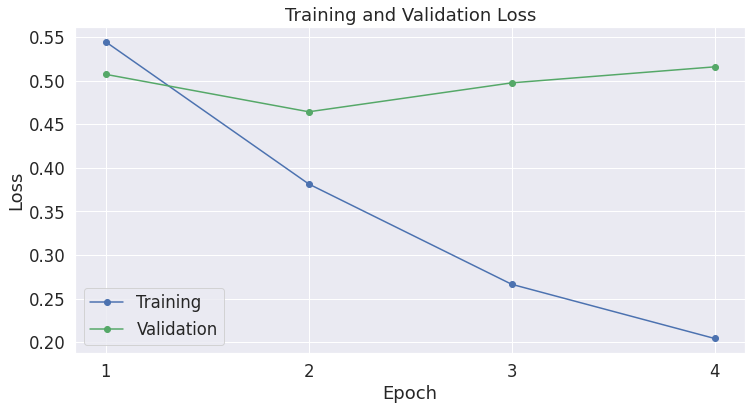

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 

# use plot styling from seaborn
sns.set(style='darkgrid')

# increase the plot size and font size
sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12,6)

# plot the learning curve
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label on the plot
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1,2,3,4])

plt.show()

# Out sample data performance

Data Preparation

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Print the number of sentences
print('Number of test sentences: {:}\n'.format(df.shape[0]))

# create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []

for sent in sentences:

  encoded_dict = tokenizer.encode_plus(sent,
                                       add_special_tokens = True,
                                       max_length = 64,
                                       padding = 'max_length',
                                       return_attention_mask = True,
                                       return_tensors = 'pt')
  
  # add tokenized sentence to id list
  input_ids.append(encoded_dict['input_ids'])

  # add attention masks to its list
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# set batch size
batch_size = 32

# create datalaoder
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



Evaluation on test dataset

In [ ]:
# Prediction on test set

print('Prediction labels for {:,} test sentences ...'.format(len(input_ids)))

# put model in evaluation mode
model.eval()

# tacking variables
predictions, true_labels = [], []

# predict
for batch in prediction_dataloader:

  # add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # unpack inputs from datalaoder
  b_input_ids, b_input_mask, b_labels = batch

  # turning calculation graph, gradient weights and backprop off
  with torch.no_grad():

    # forward pass and logit prediction calculation
    result = model(b_input_ids,
                   token_type_ids=None,
                   attention_mask=b_input_mask,
                   return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('  Run Complete.') 

Prediction labels for 516 test sentences ...
  Run Complete.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


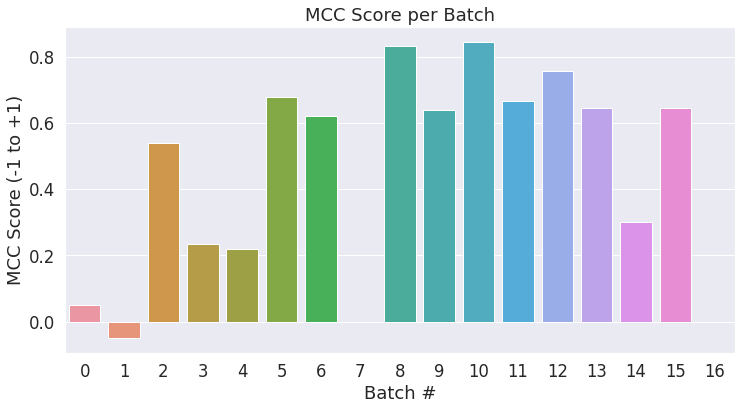

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.524
